In [1]:
import spectral.io.envi as envi
import spectral as spy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import lognorm
import statistics
import paramnormal
import pandas as pd

import datetime
import math
import os
from scipy.signal import medfilt
from pyproj import Proj, transform, CRS
from pysolar.solar import *

In [2]:
def percent_stretch(B):
    B[B<0] = 0
    minval = np.percentile(B, 5)
    maxval = np.percentile(B, 95)
    pixval = (B-minval)/(maxval-minval)
    return pixval

(920, 598, 428)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


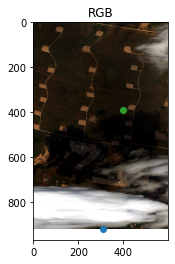

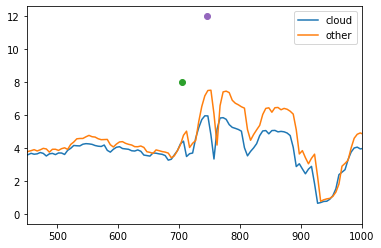

In [3]:
#img file
name = 'GAO20210730t175252'
rdn_file   = '/Users/ayasse/Airborn_data/CR/'+ name +'p0000_rdn_v2z1_clip'
data = envi.open(rdn_file+'.hdr', rdn_file)
RGB = data[:,:,0:3]
print(data.shape)
RGB[:,:,0:1]= percent_stretch(data[:,:,59])
RGB[:,:,1:2]= percent_stretch(data[:,:,38])
RGB[:,:,2:3]= percent_stretch(data[:,:,16])


plt.imshow(RGB[:,:,:])
plt.plot(310, 920, 'o', 10)
plt.plot(400, 390, 'o', 10)
plt.title("RGB")
plt.show()

temp = data[310,920,:]
temp2 = data[400,390,:]
plt.plot(np.array(data.bands.centers), temp[0,0,:], label = "cloud")
plt.plot(np.array(data.bands.centers), temp2[0,0,:], label = "other")
plt.plot(705,8, 'o', 10)
plt.plot(745,12, 'o', 10)
plt.legend()
plt.xlim(450,1000)
plt.show()

In [4]:
def GetSZA(direc,linename):
    split_ifile = list(linename)
    first_letter = split_ifile[0]
    
    if first_letter == 'G':
        #Get metadata
        with open(direc+linename + 'p0000_rdn_glt.hdr', 'rb') as f:
            content = f.readlines()
            sam = str(content[3]).split(' ')
            lin = str(content[4]).split(' ')
            map_info = str(content[12]).split(',')
        #print(lin)
        #print(sam)
        #print(map_info)
        
        n_sam = float(str(sam[2]).split('\\')[0])
        n_lin = float(str(lin[2]).split('\\')[0])
        
        dy = float(map_info[5])
        dx = float(map_info[6])
        zone = str(int(map_info[7]))
        easting = float(map_info[3])
        northing = float(map_info[4])
        dx_dy = [dx, dy]
        
        #Get lat/lon coordinates
        utm_x = easting + np.arange(0, (n_sam * dx_dy[1]), dx_dy[1])
        utm_y = northing - np.arange(0, (n_lin * dx_dy[0]), dx_dy[0])
        utm_gridx_nonrotated, utm_gridy_nonrotated = np.meshgrid(utm_x, utm_y)
        
        crs = CRS.from_string('+proj=utm +zone=' + zone + ' +north')
        myProj = Proj(crs.to_authority())
        #myProj = Proj("+proj=utm +zone=" + zone + ", +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
        slon, slat = myProj(utm_gridx_nonrotated, utm_gridy_nonrotated, inverse=True)
    else:
        print("there is a problem and this is looking for AVNG data")
        rdn = envi.open(pre_dir + ifile + '.hdr', pre_dir + ifile)
        with open(pre_dir + ifile + '.hdr', 'rb') as f:
            content = f.readlines()
            map_info = str(content[11]).split(',')
    
        dy = float(map_info[6])
        dx = float(map_info[5])
        zone = str(int(map_info[7]))
        easting = float(map_info[3])
        northing = float(map_info[4])
        rot = float(map_info[11].split("=")[1].split('}')[0])
        dx_dy = [dx, dy]
    
        #Get lat/lon coordinates
        utm_x = easting + np.arange(0, (rdn.shape[1] * dx_dy[1]), dx_dy[1])
        utm_y = northing - np.arange(0, (rdn.shape[0] * dx_dy[0]), dx_dy[0])
        utm_gridx_nonrotated, utm_gridy_nonrotated = np.meshgrid(utm_x, utm_y)
    
        #Get rotation
        theta = (math.pi/180) * (-1*rot)
        rot_mat = np.array([[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]])
        def rot_point(theta, x, y):
            xx = x - utm_x[0]
            yy = y - utm_y[0]
    
            new_x = (math.cos(theta) * xx) + (math.sin(theta) * yy)
            new_y = (-math.sin(theta) * xx) + (math.cos(theta) * yy)
    
            return new_x + utm_x[0], new_y + utm_y[0]
    
        utm_grid_x, utm_grid_y = rot_point(theta, utm_gridx_nonrotated, utm_gridy_nonrotated)
    
        rs = CRS.from_string('+proj=utm +zone=' + zone + ' +north')
        myProj = Proj(crs.to_authority())
        #myProj = Proj("+proj=utm +zone=" + zone + ", +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
        slon, slat = myProj(utm_gridx_nonrotated, utm_gridy_nonrotated, inverse=True)
    
    
    
    #Get mean lat/lon of scene
    mean_lon = np.mean(slon)
    mean_lat = np.mean(slat)
    
    #Get overpass time
    yy = linename[3:7]
    mm = linename[7:9]
    dd = linename[9:11]
    hh = linename[12:14]
    MM = linename[14:16]
    ss = linename[16:18]
    dtime = datetime.datetime(int(yy), int(mm), int(dd), int(hh), int(MM), int(ss), tzinfo = datetime.timezone.utc)
    
    #Compute solar zenith angle
    SZA = 90 - get_altitude(mean_lat, mean_lon, dtime)
    
    return(SZA)
print(GetSZA('/Users/ayasse/Airborn_data/CR/', name))
sza = GetSZA('/Users/ayasse/Airborn_data/CR/', name)

19.694622468964056


In [5]:
def GetDOY(linename):
    #Get overpass time
    yy = linename[3:7]
    mm = linename[7:9]
    dd = linename[9:11]
    hh = linename[12:14]
    MM = linename[14:16]
    ss = linename[16:18]
    dtime = datetime.datetime(int(yy), int(mm), int(dd), int(hh), int(MM), int(ss), tzinfo = datetime.timezone.utc)
    day_of_year = dtime.timetuple().tm_yday
    return(day_of_year)
print(GetDOY( name))
doy = GetDOY( name)

211


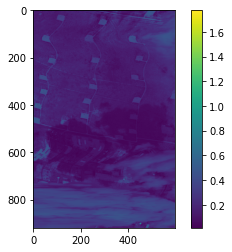

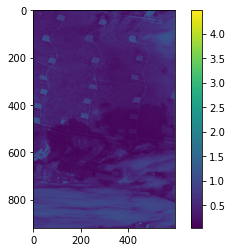

In [7]:
def ToaRef(wvl,data, sza, doy):
    d = (1-0.01672*np.cos(np.radians(0.9856*(doy-4))))# earth sun distance for a given day of the year
    pi = math.pi# pi 
    theta = sza
    wvl = wvl # input wvl
    
    # get the solar illumination
    TAOirad = pd.read_csv('astmg173_read.csv',header=0,index_col=False) #read in TAO dataset from directory
    wvl_arry = TAOirad.Wvlgth.to_numpy() # get wvl as a np array
    irad_arry = TAOirad.DC.to_numpy() #get iradiance as a np arry
    idx = np.argmin(abs(wvl_arry-wvl)) #find the idex that matched the wvl of desire
    s = irad_arry[idx]# solar illumination (using TOA solar irradiance in W/m2/nm)
   
    
    idx2 = np.argmin(abs(np.array(data.bands.centers)- wvl))# get the wvl index from rad data
    y = data[:,:,int(idx2)]*(1e-6)*100**2#original units uW/nm/cm/sr and convert to radiance value in W/nm/sr/m2 
    
    z = ((pi * d**2*y)/(np.cos(np.radians(theta))*(s)))#*y # paper implimentation
    return(z)


z1 = ToaRef(2140, data, sza, doy)
z2 = ToaRef(1250, data, sza, doy)

plt.imshow(z1)
plt.colorbar()
plt.show()

plt.imshow(data[:,:,352])
plt.colorbar()
plt.show()



In [11]:
#threshold for dark
bandrange = (480, 850, 1600, 2200)
threshold = (0.3,0.05, 0.01)
#####################################
# Calculate simple cloud screening based on Thompson et al. 2014 
rfl480 = ToaRef(bandrange[0],data, sza, doy)
rfl850 = ToaRef(bandrange[1],data, sza, doy)
rfl1600 = ToaRef(bandrange[2],data, sza, doy)
rfl2200 = ToaRef(bandrange[3],data, sza, doy)

is_dark1 = rfl850 < threshold[1] 
is_dark2 = rfl1600 < threshold[2] 
is_water = np.logical_or(is_dark1[:,:,0] == 1, is_dark2[:,:,0] == 1)

is_bright1 = rfl850 > threshold[0] 
is_bright2 = rfl1600 > threshold[0]
is_cloud = np.logical_or(is_bright1[:,:,0] == 1, is_bright2[:,:,0] == 1)

is_mask = np.logical_or(is_cloud[:,:,0] == 1, is_bright2[:,:,0] == 1)

maskidx = lambda mask: where((~(mask==0)))[0]# last & statment    read_mask(inputfile):
cols = data.shape[1]
bands = data.shpae[2]
rows = data.shape[0]      
        
Icol_full_orig=img_mm[:,:,:]
Icol_full = np.zeros((rows*cols,bands))
for i in range(0,cols):
    Icol_full[i*rows:(i+1)*rows,:]= Icol_full_orig[:,:,i]                
        
       
is=is_water[:,:]
s_mask_full = np.zeros(rows*cols)
                for i in range(0,col_group):
                    s_mask_full_orig_col = s_mask_full_orig[:,i]
                    s_mask_full[i*nrows:(i+1)*nrows]=  s_mask_full_orig_col[:,0]
            maskuse = maskidx(s_mask_full)
            #pixels to use
            Icol_full = Icol_full.copy() 
            Icol_full[maskuse] = -1
        
        
        use = useidx(Icol_full)
        Icol = float64(Icol_full[use,:])
        nuse = Icol.shape[0]
        
        print("number of pixels", Icol.shape[0])
        if nuse == 0:
            continue
        if bgmodes > 1:
            # PCA projection down to a smaller number of dimensions 
            # then apply K-means to separate spatially into clusters
            Icol_zm = Icol-colavgfn(Icol,axis=0)
            evals,evecs = eig(cov(Icol_zm))
            Icol_pca = Icol_zm.dot(evecs[:,:pcadim]) 
            cmodel = MiniBatchKMeans(n_clusters=bgmodes)
            bglabels = cmodel.fit(Icol_pca).labels_
            bgulab = unique(bglabels)
            
            bgcounts = []
            bgulabn = zeros(len(bgulab))
            for i,l in enumerate(bgulab):
                lmask = bglabels==l
                bgulabn[i] = lmask.sum()
                if reject and bgulabn[i] < bgminsamp:
                    print('flagged outlier cluster %d (%d samples)'%(l,bgulabn[i]))
                    bglabels[lmask] = -l
                    bgulab[i] = -l                                    
                bgcounts.append("%d: %d"%(l,bgulabn[i]))
                if savebgmeta:
                    bgimg_mm[use[lmask],col,0] = bgulab[i]

            print('bg cluster counts:',', '.join(bgcounts))
            if (bgulab<0).all():
                warn('all clusters rejected, proceeding without rejection (beware!)')
                bglabels,bgulab = abs(bglabels),abs(bgulab)
                
        else: # bgmodes==1
            bglabels = ones(nuse)
            bgulab = array([1])

        # operate independently on each columnwise partition
        for ki in bgulab:
            # if bglabel<0 (=rejected), estimate using all (nonrejected) modes
            kmask = bglabels==ki if ki >= 0 else bglabels>=0

            # need to recompute mu and associated vars wrt this cluster
            Icol_ki = (Icol if bgmodes == 1 else Icol[kmask,:]).copy()     
            
            Icol_sub = Icol_ki.copy()
            mu = colavgfn(Icol_sub,axis=0)
            
            # reinit model/modelfit here for each column/cluster instance
            if modelname == 'empirical':
                modelfit = lambda I_zm: cov(I_zm)
            elif modelname == 'looshrinkage':
                # optionally use the full zero mean column as a regularizer
                Icol_reg = Icol-mu if (regfull and bgmodes>1) else []
                modelfit = lambda I_zm: looshrinkage(I_zm,alphas,nll,
                                                     nuse,I_reg=Icol_reg)
                
            try:                            
                Icol_sub = Icol_sub-mu # = subsampled column mode

                Icol_model = modelfit(Icol_sub)
                if modelname=='looshrinkage':
                    C,alphaidx = Icol_model
                    Cinv=inv(C)
                    if savebgmeta:
                        bgimg_mm[use[kmask],col,1] = alphaidx
                elif modelname=='empirical':
                    Cinv = inv(Icol_model)
                else:
                    Cinv = Icol_model
                    
            except LinAlgError:
                print('singular matrix. skipping this column mode.')
                if col_group > 1:
                    for i in range(1,col_group):
                        outimg_mm[:,col:col1,-1] = 0
                else:
                    outimg_mm[use[kmask],col,-1] = 0
                continue
            
            # Classical matched filter
            Icol_ki = Icol_ki-mu # = fully-sampled column mode
            target = abscf.copy()
            target = target-mu if reflectance else target*mu
            normalizer = target.dot(Cinv).dot(target.T)
            mf_orig = (Icol_ki.dot(Cinv).dot(target.T)) / normalizer
            
            
            if col_group > 1:
                mf_long = np.zeros(nrows*col_group)
                mf_long[use[kmask]] = mf_orig
                
                mf = np.zeros((nrows,col_group))
                
                for i in range(0,col_group):
                    mf[:,i]= mf_long[i*nrows:(i+1)*nrows]
                    
            else:
                mf = np.zeros((nrows,col_group))
                mf[use[kmask],0] = mf_orig
                
            if reflectance:
                outimg_mm[use[kmask],col,-1] = mf 
            else:
                outimg_mm[:,col:col1,-1] = mf*ppmscaling
        
        colmu = outimg_mm[:,col:col1,-1].mean()
        print('Column %i mean: %e'%(col,colmu))
        # copy rgb bands to outfile        
        #outimg_mm[:,col,0] = img_mm[:,rgb_bands[0],col]
        #outimg_mm[:,col,1] = img_mm[:,rgb_bands[1],col]
        #outimg_mm[:,col,2] = img_mm[:,rgb_bands[2],col]



plt.imshow(cov)
plt.colorbar()
plt.show()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 37)

In [12]:
def get_cloud_mask(data: np.ndarray, sza, doy):
    """Calculates a mask of pixels that appear to be clouds.
    Pixels containing ANY radiance value above the provided threshold at the specified wavelength.

    :param data: Radiance image to screen for sensor saturation.
    :param sza: solar zenith angle for the image
    :param doy: daoy of year for the image (where Jan 1 is 1 ect).

    :return: Binary Mask with 1/True where clouds occur, 0/False for normal pixels.
    """
    #if threshold is None:
    threshold = (.28, 0.25,0.22) #from Sanford et al. FP 1000, midlat. 
    # other thresholds:
    # Tropics:  (.31, 0.34,0.13)
    # Arctic: (.47, .57, 0.3)
    # Ocean: (.42,.37, .3)
    #if bandrange is None:
    bandrange = (447, 1246, 1650) # AVIRIS-NG bands that will be used based on Thompson et al. 2014, corrsponding to 450 and 1250 nm, 
    # Calculate simple cloud screening based on Thompson et al. 2014 
    rdn1 = ToaRef(bandrange[0],data, sza, doy)
    rdn2 = ToaRef(bandrange[1],data, sza, doy)# this is for snow, not an issue yet
    rdn3 = ToaRef(bandrange[2],data, sza, doy)# this is for snow, not an issue yet
    is_bright447 = rdn1 > threshold[0]
    is_bright1246 = rdn2 > threshold[1]
    is_bright1650 = rdn3 > threshold[2]


    # Combine if the radiance at 450 nm is bright (is_bright) and isNot_snow 
    is_cloud = np.logical_and(  is_bright447[:,:,0] == 1, is_bright1246[:,:,0] == 1, is_bright1650[:,:,0] == 1 )
    
    #return is_bright447
    return is_cloud    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


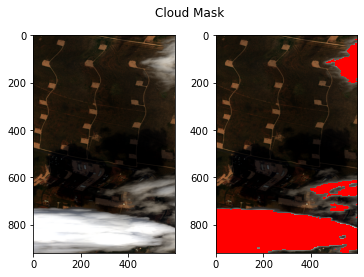

In [13]:
threshold = False
test = get_cloud_mask(data, sza,doy)
masked_cloud = np.ma.masked_where(test[:,:] == 0, test[:,:])
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Cloud Mask')
ax1.imshow(RGB[:,:,:])
ax2.imshow(RGB[:,:,:])
ax2.imshow(masked_cloud, cmap='autumn')

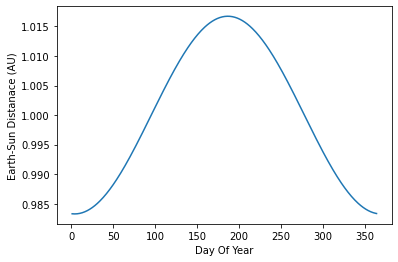

In [9]:
D = np.arange(1, 365, 1,dtype=float)
doy = np.arange(1, 365, 1,dtype=int)

for i in doy:
    D[i-1] = (1-0.01672*np.cos(np.radians(0.9856*(i-4))))
#print(D)
    
plt.plot(doy, D)
plt.xlabel('Day Of Year')
plt.ylabel('Earth-Sun Distanace (AU)')
plt.show()